In [3]:
import tensorflow as tf  # Core TensorFlow library
 
from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks
 
from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models
 
from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning
 
from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet
 
import numpy as np  # Numerical operations and array handling
 
import matplotlib.pyplot as plt  # Plotting graphs and images
 
import seaborn as sns  # Plotting graphs and images
 
from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models
 
import gradio as gr  # Web interface library to deploy and test ML models
 
from PIL import Image  # For image file loading and basic image operations

c:\Users\roshe\Downloads\archive\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FORMAT :  FOLDER BASED IMAGE CLASSIFICATION DATASET

Train/: Images used for training the model

Test/: Images used for model evaluation

Validation/: Images used to fine-tune and validate the model

In [1]:
testpath= r'C:\Users\roshe\Downloads\archive\modified-dataset\test'
trainpath= r'C:\Users\roshe\Downloads\archive\modified-dataset\train'
validpath = r'C:\Users\roshe\Downloads\archive\modified-dataset\val'

1. EXPLORE AND UNDERSTAND DATA

Load image dataset using tools like image_dataset_from_directory.
Visualize sample images from each class.
Check the number of images per class to ensure balance.
Understand image dimensions, color channels, and class labels.

LOAD IMAGE DATASET USING TOOL LIKE image_dataset_from_directory.

SPLIT DATASET INTO TRAINING, VALIDATION AND TESTING SETS.

tf.keras.utils.image_dataset_from_directory(...)
Used to load images from a directory where each subfolder represents a class.

path
Root directory path containing one subdirectory per class.

shuffle=True
Randomly shuffles the image data. Useful during training to prevent the model from learning the order of the data.

image_size=(128, 128)
Resizes all loaded images to this target size (width, height).
This must match the input size expected by the model.

batch_size=32
Number of images per batch during training.
This affects memory usage and the frequency of model updates.

validation_split=False
If set to a float (e.g., 0.2), splits a portion of the data for validation.
If False, no split is applied.

In [4]:

datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [5]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [6]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [7]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


VISUALIZE SAMPLE IMAGE FROM EACH CLASS

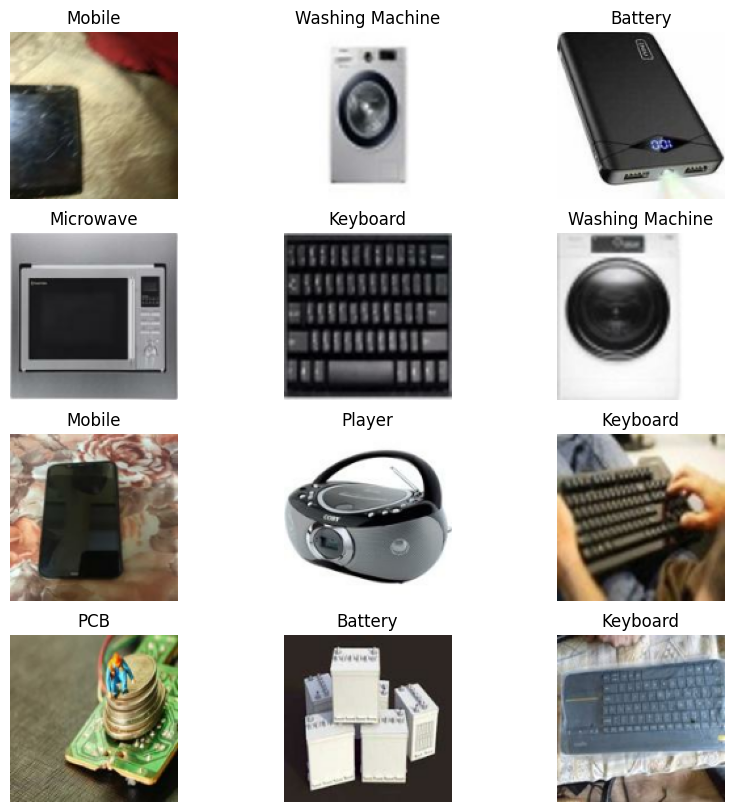

In [8]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

Check the number of images per class to ensure balance

Understand image properties like Image dimensions, Class labels

In [9]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

In [20]:
    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

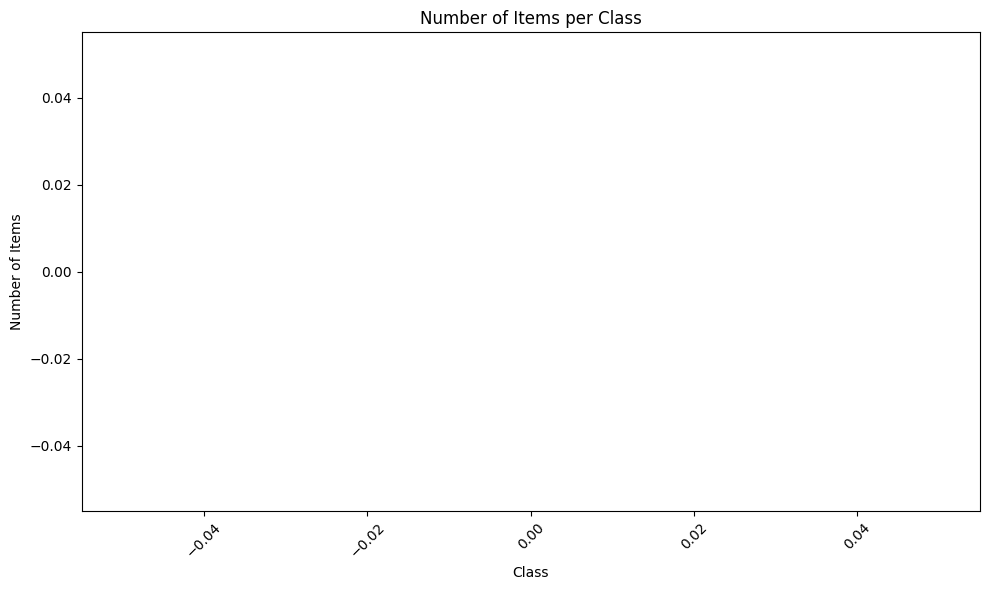

In [26]:
title = "Number of Items per Class"  # 📝 Define the title

plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
plt.xlabel("Class")  # X-axis label
plt.ylabel("Number of Items")  # Y-axis label
plt.title(title)  # Plot title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot


In [28]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

2. DATA PRE-PROCESSING


In [29]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

3. MODEL SELECTION

In [30]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

CALLBACKS

In [32]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

TRAIN MODEL USING .fit() WITH APPROPRIATE epochs, batch_size, and callbacks LIKE EARLYSTOPPING

In [12]:
import tensorflow as tf

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\roshe\Downloads\archive\modified-dataset",
    image_size=(224, 224),
    batch_size=32
)

# Get class names 💡
class_names = train_ds.class_names

# Define number of classes 🌟
num_classes = len(class_names)


Found 3000 files belonging to 3 classes.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # You already defined num_classes earlier 💡
])


In [20]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

datatrain = image_dataset_from_directory(
    r"C:\Users\roshe\Downloads\archive\modified-dataset\train",  # 🗂️ path to your training data
    image_size=(224, 224),
    batch_size=32
)

datavalid = image_dataset_from_directory(
    r"C:\Users\roshe\Downloads\archive\modified-dataset\val",  # 🗂️ path to your validation data
    image_size=(224, 224),
    batch_size=32
)


Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Then pass both callbacks:
callbacks=[early, checkpoint]




In [31]:
class_names = datatrain.class_names
num_classes = len(class_names)
print("Detected Classes:", class_names)


Detected Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [32]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input

base_model = EfficientNetV2B0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # 🌟 CORRECT!

model = Model(inputs, outputs)


In [33]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [35]:
epochs = 15

history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    batch_size=100,  # optional, depends on your system
    callbacks=[early]
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 599ms/step - accuracy: 0.5784 - loss: 1.4773 - val_accuracy: 0.9533 - val_loss: 0.3022
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 570ms/step - accuracy: 0.9390 - loss: 0.2939 - val_accuracy: 0.9600 - val_loss: 0.1873
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 564ms/step - accuracy: 0.9599 - loss: 0.1887 - val_accuracy: 0.9633 - val_loss: 0.1472
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 571ms/step - accuracy: 0.9691 - loss: 0.1439 - val_accuracy: 0.9667 - val_loss: 0.1272
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - accuracy: 0.9757 - loss: 0.1180 - val_accuracy: 0.9700 - val_loss: 0.1162
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 788ms/step - accuracy: 0.9760 - loss: 0.1026 - val_accuracy: 0.9733 - val_loss: 0.1112
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 700ms/step - accuracy: 0.9808 - loss: 0.0862 - val_accuracy: 0.9767 - val_loss: 0.1070
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 627ms/step - accuracy: 0.9814 - loss: 0.0746 - val_accu

Model Architechure of EfficientNETV2

In [36]:
model.summary() # Print the architecture summary of the  model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [37]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

MODEL PERFORMANCE VISUALIZATION: ACCURACY & LOSS TRENDS

In [39]:
# 🌟 Training metrics
acc = history.history['accuracy']           # ✅ lowercase 'accuracy'
val_acc = history.history['val_accuracy']   # ✅ lowercase 'val_accuracy'
loss = history.history['loss']
val_loss = history.history['val_loss']


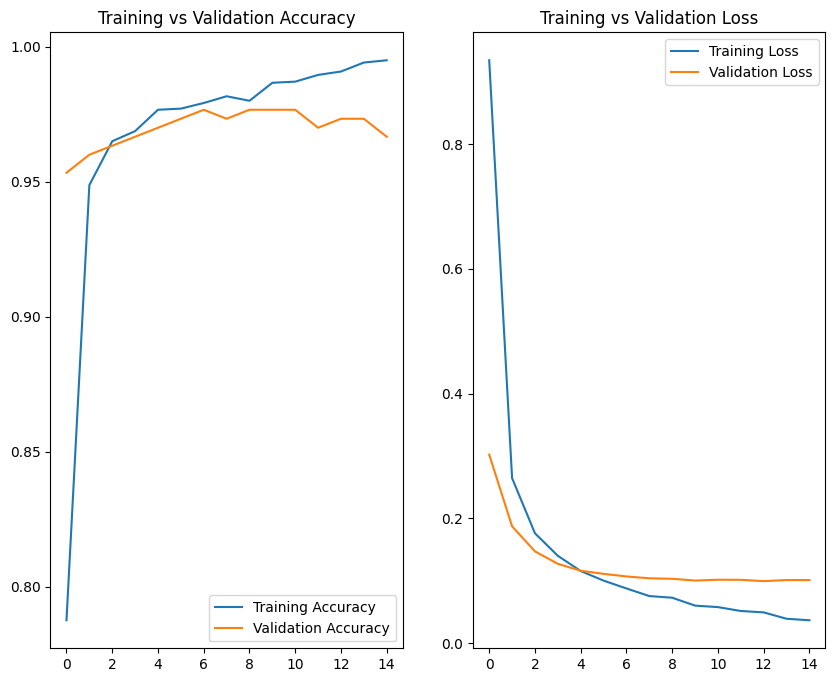

In [41]:
import matplotlib.pyplot as plt  # 🌸 Add this line!

epochs_range = range(len(acc))  # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))     # Set overall figure size

# 💫 Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# 💔 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


6. MODEL EVALUATION

In [43]:
# 🌟 Load the test dataset
datatest = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\roshe\Downloads\archive\modified-dataset\test",
    image_size=(224, 224),
    batch_size=32
)


Found 300 files belonging to 10 classes.


In [44]:
AUTOTUNE = tf.data.AUTOTUNE
datatest = datatest.prefetch(buffer_size=AUTOTUNE)


In [45]:
# 🧠 Evaluate the trained model
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - accuracy: 0.9617 - loss: 0.0885
Test accuracy is 0.9700, Test loss is 0.0773


In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report  # just in case

# 🌸 Extract true labels
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)

# 💫 Predict class probabilities
y_pred_probs = model.predict(datatest)

# 🌟 Convert to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# 🧾 Print results
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step
[[5 4 2 3 3 6 3 2 2 0]
 [1 3 2 2 3 2 4 7 1 5]
 [3 5 2 3 6 2 3 2 0 4]
 [1 0 6 3 4 2 1 5 6 2]
 [4 5 2 4 4 4 1 1 2 3]
 [2 0 1 5 4 3 3 3 3 6]
 [0 4 4 4 3 3 4 1 5 2]
 [4 5 2 2 0 5 2 4 3 3]
 [4 3 5 2 3 2 5 1 4 1]
 [3 1 6 2 2 2 2 4 3 5]]
              precision    recall  f1-score   support

           0       0.19      0.17      0.18        30
           1       0.10      0.10      0.10        30
           2       0.06      0.07      0.06        30
           3       0.10      0.10      0.10        30
           4       0.12      0.13      0.13        30
           5       0.10      0.10      0.10        30
           6       0.14      0.13      0.14        30
           7       0.13      0.13      0.13        30
           8       0.14      0.13      0.14        30
           9       0.16      0.17      0.16        30

    accuracy                           0.12       300
   macro avg       0.12      0.12      0.12       300
weighted avg       0.12 

c:\Users\roshe\Downloads\archive\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128171 (\N{DIZZY SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


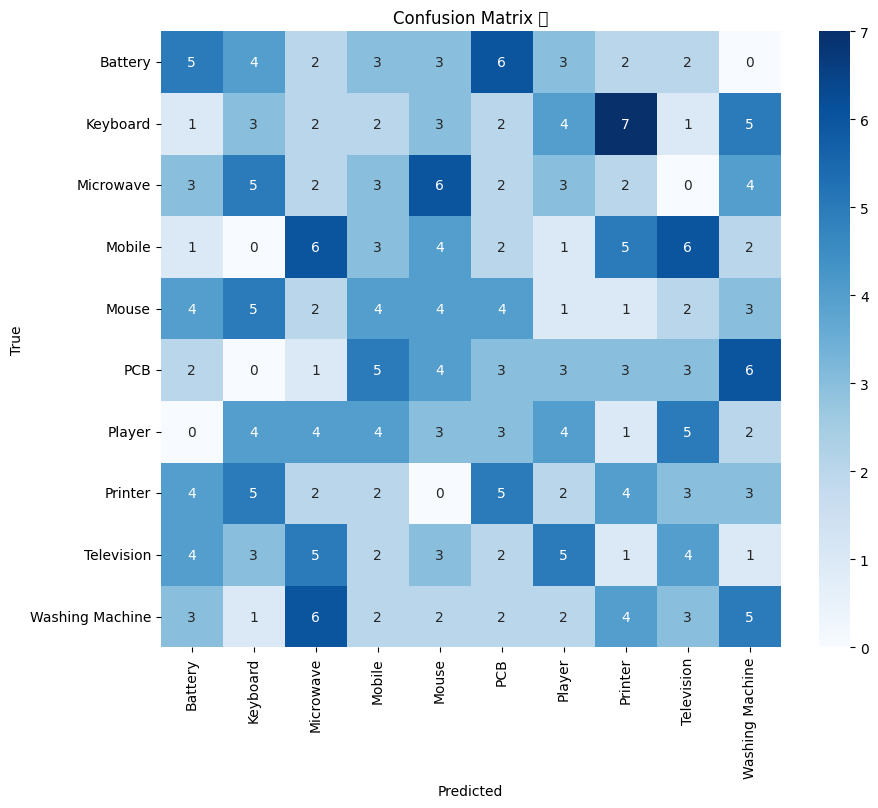

In [49]:
import seaborn as sns  # 🌸 Add this to use sns.heatmap

# 💙 Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 🌈 Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix 💫')
plt.show()


7.FINAL TESTING

In [52]:
# 🌼 Step 1: Load test dataset and keep a reference
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\roshe\Downloads\archive\modified-dataset\test",
    image_size=(224, 224),
    batch_size=32
)

# 🌟 Step 2: Use prefetch version for training speed
datatest = raw_test_ds.prefetch(buffer_size=AUTOTUNE)

# 🌈 Step 3: Get class names from original unmodified dataset
class_names = raw_test_ds.class_names


Found 300 files belonging to 10 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


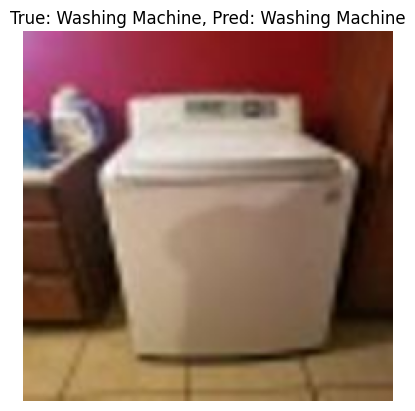

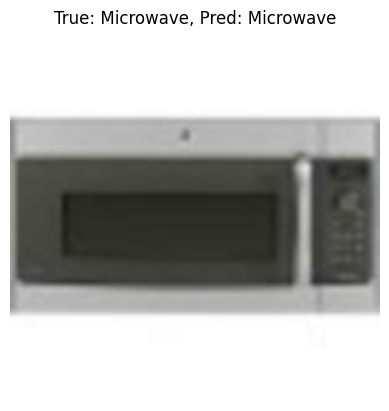

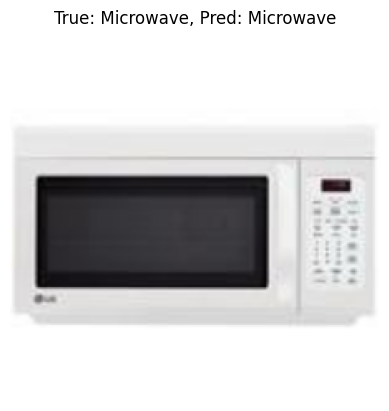

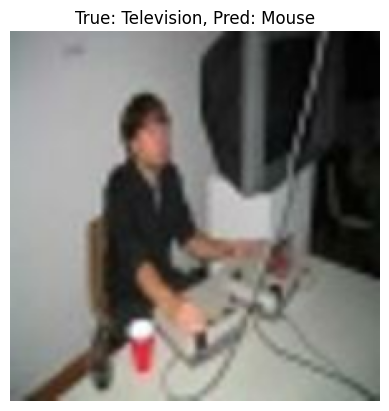

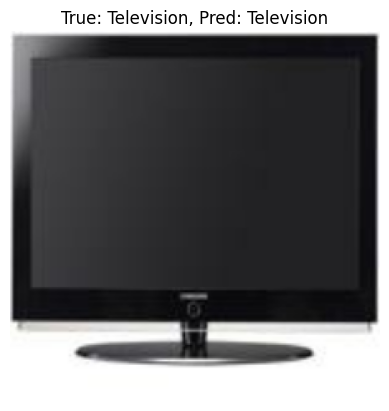

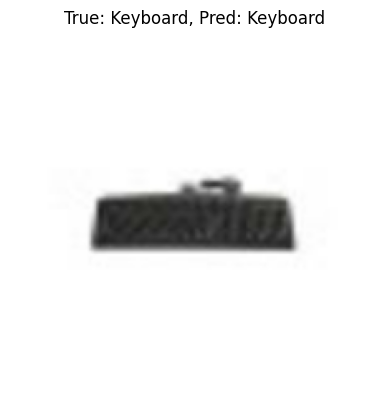

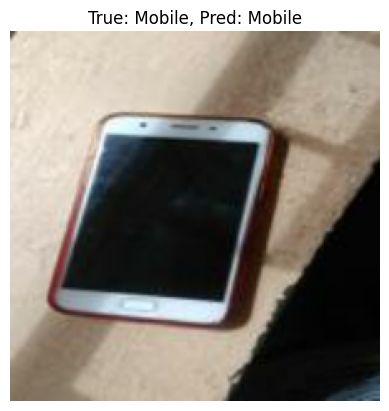

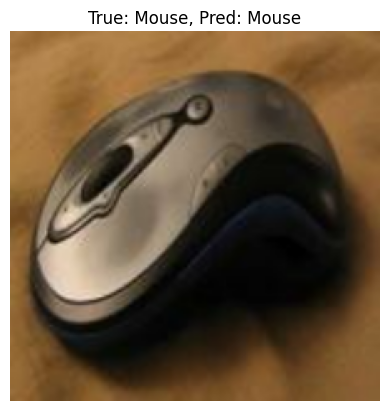

In [53]:
for images, labels in datatest.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


In [54]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [55]:

# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

MODEL DEPLOYMENT

In [56]:
!pip install gradio

In [58]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

In [60]:
def classify_image(image):
    # Resize the image to match model input
    img = image.resize((224, 224))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)  # Normalize & reshape

    predictions = model.predict(img_array)
    class_index = np.argmax(predictions[0])
    return class_names[class_index]  # 'class_names' should be previously defined


In [1]:
import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf

# Load your trained model (uncomment and provide path if you have one)
# model = tf.keras.models.load_model("your_model.h5")

# Placeholder model and prediction function for demonstration if model is not available
# You should replace this with your actual model and prediction logic
class DummyModel:
    def predict(self, img_array):
        # Simulate a prediction for demonstration
        return np.array([[0.01, 0.01, 0.01, 0.9, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])

model = DummyModel() # Replace with your actual model loading

# Example class names
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse',
               'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Prediction function
def classify_image(image):
    if image is None:
        return "Please upload an image."
    img = image.resize((224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction[0])
    return f"{class_names[class_index]}"

# Custom CSS with the recycling symbol background
custom_css = """
/* Force the background image onto the entire document and fix it */
html, body, #root, .gradio-app, .gradio-wrap, .gradio-app-container, .gr-main, .gradio-body, .gradio-column, .gradio-row {
    background-image: url("https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.istockphoto.com%2Fphotos%2Fe-waste-recycling&psig=AOvVaw39bapX6fH6H6avmquCnet2&ust=1750524973160000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCICavu27gI4DFQAAAAAdAAAAABA5") !important;
    background-size: cover !important;
    background-position: center !important;
    background-repeat: no-repeat !important;
    background-attachment: fixed !important; /* Keep background fixed when scrolling */
    min-height: 100vh !important;
    font-family: 'Segoe UI', sans-serif;
    margin: 0 !important; /* Ensure no default margins */
    padding: 0 !important; /* Ensure no default padding */
    background-color: transparent !important; /* Crucial to override any default white background */
    overflow-x: hidden; /* Prevent horizontal scrollbar if image causes it */
}

/* Ensure the main Gradio container has a semi-transparent background for content readability */
.gradio-container {
    background-color: rgba(255, 255, 255, 0.85); /* Semi-transparent white */
    padding: 40px;
    border-radius: 16px;
    max-width: 850px;
    margin: 50px auto;
    box-shadow: 0 0 25px rgba(0, 0, 0, 0.4);
    color: #333;
}

.center-text {
    text-align: center;
    color: #006400; /* Darker green for better contrast */
    margin-bottom: 20px;
}

.gr-button {
    background-color: #006400 !important; /* Darker green */
    color: white !important;
    font-weight: bold;
    border-radius: 10px;
    padding: 12px 24px;
    margin-top: 10px;
    border: none;
    transition: all 0.3s ease;
}

.gr-button:hover {
    background-color: #004d00 !important; /* Even darker green on hover */
    transform: translateY(-2px);
}

.step-container {
    display: flex;
    justify-content: space-around;
    margin-bottom: 30px;
    flex-wrap: wrap;
    gap: 20px;
}

.step-box {
    background: rgba(255, 255, 255, 0.9);
    border-radius: 12px;
    padding: 20px;
    width: 240px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.2);
    text-align: center;
    color: #333;
    transition: all 0.3s ease;
}

.step-box:hover {
    transform: translateY(-5px);
    box-shadow: 0 6px 16px rgba(0,0,0,0.3);
}

.step-box h4 {
    font-size: 18px;
    margin-bottom: 10px;
    color: #006400;
}

.step-box p {
    font-size: 14px;
}

/* Make the content more readable against the background */
.gr-input, .gr-textbox {
    background-color: rgba(255, 255, 255, 0.9) !important;
}
"""

# Gradio interface
with gr.Blocks(css=custom_css) as app:
    gr.Markdown("<h1 class='center-text'>EcoSort</h1>")
    gr.Markdown("<h3 class='center-text'>Intelligent Classification of Electronic Waste Using AI</h3>")

    gr.Markdown("<h2 class='center-text'>How to Use This Classifier</h2>")
    gr.HTML("""
    <div class='step-container'>
        <div class='step-box'>
            <h4>Step 1: Upload Image</h4>
            <p>Select or drag an image of your e-waste (e.g., mobile, battery, PCB).</p>
        </div>
        <div class='step-box'>
            <h4>Step 2: Click Classify</h4>
            <p>Use the green button below to process the image.</p>
        </div>
        <div class='step-box'>
            <h4>Step 3: View Result</h4>
            <p>The predicted e-waste category will appear beneath the button.</p>
        </div>
    </div>
    """)

    image_input = gr.Image(label="Upload E-Waste Image", type="pil")
    predict_btn = gr.Button("Classify")
    prediction_output = gr.Textbox(label="Predicted Category", lines=1)

    predict_btn.click(fn=classify_image, inputs=image_input, outputs=prediction_output)

# Launch app
app.launch()

c:\Users\roshe\Downloads\archive\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
